In [1]:
#data preprocessing
import numpy as np
import pyodbc
import pandas as pd

#ml stuff
import sklearn
from sklearn.model_selection import train_test_split
from tensorflow import keras 
import tensorflow as tf
print('Tensorflow/Keras: %s' % keras.__version__)
from keras.models import Sequential 
from keras import Input 
from keras.layers import Dense
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.cluster import KMeans
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.datasets import make_regression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import itertools
import functools
import operator 
from more_itertools import flatten
from collections import Counter

#utils/visualization
import time
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import dill as pickle
from ydata_profiling import ProfileReport
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.express as px

#config vars
pd.options.display.max_columns=1000
pd.options.display.max_rows = 10000
pd.options.display.max_seq_items = 100
verbose=1

Tensorflow/Keras: 2.12.0


# Connect to Database and get Data

In [2]:
def connect_to_db(connection_string,
                    database,
                    driver = 'SQL Server Native Client 11.0',
                    user = 'CCAdmin',
                    password = 'Miw6RjnTGmPHLYF9mG1o'
):
    connection = pyodbc.connect("Driver={"+driver+"};"
                        "Server="+connection_string+";"
                        "Database="+database+";"
                        "uid="+user+";pwd="+password+"")
    return connection

In [3]:
def get_table_data(table_name, connection):
    query = "SELECT * FROM {}".format(table_name)
    df = pd.read_sql_query(query, connection)

    return df

In [4]:
tenant = '0001ai'

In [20]:

#get all tables
#cursor = connect_to_db().cursor()
#tables_list = list(cursor.tables())

#connection_string='classconprocessingger.database.windows.net'

df_table_cclogattributes = get_table_data('CCLogAttributes', connect_to_db(connection_string= 'classconprocessingger.database.windows.net', database = 'T_'+tenant+''))
#df_table_cclogdocuments = get_table_data('CCLogDocuments', connect_to_db(database='T_0000xu'))
#df_table_cclogdocuments.to_pickle(df_table_cclogattributes)

#df_table_cclogattributes = df_table_cclogattributes.drop('LogTime', axis=1)
df_table_cclogattributes = df_table_cclogattributes.drop(['Zone','Attribute_DataType','LogTimeTicks'], axis=1)

df_table_cclogattributes = df_table_cclogattributes.replace('\n',' ', regex=True)
df_table_cclogattributes = df_table_cclogattributes.replace('\r',' ', regex=True)
df_table_cclogattributes.to_csv('data/cclogattributes_T_'+tenant+'.csv', index=False, header= True, encoding='utf-8')#iso-8859-15


C:\Users\lete\AppData\Local\Temp\ipykernel_8260\2297382259.py:3: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



# Data analysis


In [44]:
#df.head()
#ProfileReport(df)

In [5]:
dist = df['Delta'].value_counts()
trace = go.Pie(values=(np.array(dist)),labels=dist.index,  pull=[0, 0])
layout = go.Layout(title='Delta Distribution')
data = [trace]
fig = go.Figure(trace,layout)
fig.update_traces(marker=dict(line=dict(color='#000000', width=0.5)), textinfo='value+percent', insidetextorientation='auto')
#sfig.show()

In [6]:
dist = df['Type'].value_counts()
trace = go.Pie(values=(np.array(dist)),labels=dist.index,  pull=[0, 0.4,0.2,0.1])
layout = go.Layout(title='Type Distribution')
data = [trace]
fig = go.Figure(trace,layout)
fig.update_traces(marker=dict(line=dict(color='#000000', width=0.5)), textinfo='value+percent', insidetextorientation='auto')
#sfig.show()

# Sollerkennungswerte bestimmen


In [5]:
def get_sollwerte(key, df):
    df_ordernum = df.loc[(df['Attribute_Name'] == 'OrderNum')] #&(df['Delta'] == False)
    dist = df_ordernum['Delta'].value_counts(normalize=True)
    print('Kreditor: '+key+'')
    
    try:
        score = 1 - dist.loc[True]
    except:
        score = dist.loc[False]

    print('q(OrderNum): '+str(score)+'') 


    df_ordernum_correct = df.loc[(df['Attribute_Name'] == 'OrderNum') &(df['Delta'] == False)] 
    documentid_list = df_ordernum_correct[['DocumentID']].values.tolist()
    merged = list(itertools.chain.from_iterable(documentid_list))
    denonimator_ordernum = len(documentid_list)
    

    df_debitor_ordernum = df.loc[(df['Attribute_Name'] == 'OrderNum')|(df['Attribute_Name'] == 'DEBITOR_NUM')|(df['Attribute_Name'] == 'VENDOR_NUM')]
    #print(df_debitor_ordernum)
    #df_debitor_ordernum.to_csv('data/debitor_preprocessing.csv', index=False, header= True, encoding='iso-8859-15')



    counter_do=0
    counter_vo=0
    for entry_1 in merged:
        speicher_entry_new = df_debitor_ordernum[df_debitor_ordernum.DocumentID == ''.join(str(entry_1))]
        if ((speicher_entry_new.Attribute_Name == 'OrderNum') & (speicher_entry_new.Delta == False)).any(): 
            if ((speicher_entry_new.Attribute_Name == 'DEBITOR_NUM')&(speicher_entry_new.Delta == False)).any():
                    counter_do += 1
            if ((speicher_entry_new.Attribute_Name == 'VENDOR_NUM')&(speicher_entry_new.Delta == False)).any():
                    counter_vo += 1
    try:
        print('q(Mandant|OrderNum): '+str(counter_do/denonimator_ordernum)+'')
        print('q(Vendor|OrderNum): '+str(counter_vo/denonimator_ordernum)+'')
    except:
         print('error')

    counter_vno=0

    df_order_delta = df.loc[(df['Attribute_Name'] == 'OrderNum')&(df['Delta'] == True)]
    df_order_delta_documentid = df_order_delta[['DocumentID']]
    order_delta_list = df_order_delta_documentid.values.tolist()
    order_delta_list_merged = list(itertools.chain.from_iterable(order_delta_list))
    denominator_order_delta_num = len(order_delta_list_merged)


    df_invoicenumber_order_delta = df.loc[(df['Attribute_Name'] == 'DEBITOR_NUM')|(df['Attribute_Name'] == 'OrderNum')]
    for entry_order_delta_invoicenumber in order_delta_list_merged:
        speicher_entry_order_delta = df_invoicenumber_order_delta[df_invoicenumber_order_delta.DocumentID == ''.join(str(entry_order_delta_invoicenumber))]
        if ((speicher_entry_order_delta.Attribute_Name == 'OrderNum') & (speicher_entry_order_delta.Delta == True)).any(): 
            if ((speicher_entry_order_delta.Attribute_Name == 'DEBITOR_NUM') & (speicher_entry_order_delta.Delta == False)).any():
                    counter_vno += 1

    if(counter_vno == 0):
        print('Da keine falsche Ordernum existiert ist Mandant|!Ordernum 0')
    else:
        print('q(Mandant|!OrderNum): '+str(counter_vno/denominator_order_delta_num)+'')
        
    df_vendor_nodelta = df.loc[(df['Attribute_Name'] == 'VENDOR_NUM')&(df['Delta'] == False)]
    df_vendor_documentid = df_vendor_nodelta[['DocumentID']]
    vendor_list = df_vendor_documentid.values.tolist()
    vendor_list_merged = list(itertools.chain.from_iterable(vendor_list))
    denominator_vendor_num = len(vendor_list)

    df_invoicenumber_vendor = df.loc[(df['Attribute_Name'] == 'InvoiceNumber')|(df['Attribute_Name'] == 'VENDOR_NUM')|(df['Attribute_Name'] == 'InvoiceDate')|(df['Attribute_Name'] == 'InvoiceDate')|(df['Attribute_Name'] == 'GrossAmount')]

    counter_inv=0
    counter_idv=0
    counter_gv=0

    for entry_vendor_invoicenumber in vendor_list_merged:
        speicher_entry_vendor = df_invoicenumber_vendor[df_invoicenumber_vendor.DocumentID == ''.join(str(entry_vendor_invoicenumber))]
        if ((speicher_entry_vendor.Attribute_Name == 'VENDOR_NUM') & (speicher_entry_vendor.Delta == False)).any(): 
            if ((speicher_entry_vendor.Attribute_Name == 'InvoiceNumber') & (speicher_entry_vendor.Delta == False)).any():
                    counter_inv += 1
            if ((speicher_entry_vendor.Attribute_Name == 'InvoiceDate') & (speicher_entry_vendor.Delta == False)).any():
                    counter_idv += 1
            if ((speicher_entry_vendor.Attribute_Name == 'GrossAmount') & (speicher_entry_vendor.Delta == False)).any():
                    counter_gv += 1

    try:
        print('q(InvoiceNumber|Vendor): '+str(counter_inv/denominator_vendor_num)+'')
        print('q(InvoiceDate|Vendor): '+str(counter_idv/denominator_vendor_num)+'')
        print('q(Gross|Vendor): '+str(counter_gv/denominator_vendor_num)+'')
    except:
        print('error')
    counter_gnv=0

    df_vendor_delta = df.loc[(df['Attribute_Name'] == 'VENDOR_NUM')&(df['Delta'] == True)]
    df_vendor_delta_documentid = df_vendor_delta[['DocumentID']]
    vendor_delta_list = df_vendor_delta_documentid.values.tolist()
    vendor_delta_list_merged = list(itertools.chain.from_iterable(vendor_delta_list))
    denominator_vendor_delta_num = len(vendor_delta_list_merged)


    df_invoicenumber_vendor_delta = df.loc[(df['Attribute_Name'] == 'GrossAmount')|(df['Attribute_Name'] == 'VENDOR_NUM')]
    for entry_vendor_delta_invoicenumber in vendor_delta_list_merged:
        speicher_entry_vendor_delta = df_invoicenumber_vendor_delta[df_invoicenumber_vendor_delta.DocumentID == ''.join(str(entry_vendor_delta_invoicenumber))]
        if ((speicher_entry_vendor_delta.Attribute_Name == 'VENDOR_NUM') & (speicher_entry_vendor_delta.Delta == True)).any(): 
            if ((speicher_entry_vendor_delta.Attribute_Name == 'GrossAmount') & (speicher_entry_vendor_delta.Delta == False)).any():
                    counter_gnv += 1

    try:
        print('q(Gross|!Vendor): '+str(counter_gnv/denominator_vendor_delta_num)+'')
    except:
        print('errror')

    counter_vom=0

    df_order_mandant_delta = df.loc[(df['Attribute_Name'] == 'OrderNum')&(df['Delta'] == True)]
    df_order_delta_new = df_order_mandant_delta.loc[(df_order_mandant_delta['Attribute_Name'] == 'Mandant')&(df['Delta'] == False)]
    df_order_delta_mandant_documentid = df_order_delta_new[['DocumentID']]
    order_delta_mandant_list = df_order_delta_mandant_documentid.values.tolist()
    order_delta_mandant_list_merged = list(itertools.chain.from_iterable(order_delta_mandant_list))
    denominator_order_delta_mandant_num = len(order_delta_mandant_list_merged)


    df_invoicenumber_order_delta_mandant = df.loc[(df['Attribute_Name'] == 'VENDOR_NUM')|(df['Attribute_Name'] == 'OrderNum')|(df['Attribute_Name'] == 'DEBITOR_NUM')]
    for entry_order_delta_mandant in order_delta_mandant_list_merged:
        speicher_entry_order_delta_mandant = df_invoicenumber_order_delta_mandant[df_invoicenumber_order_delta_mandant.DocumentID == ''.join(str(entry_order_delta_mandant))]
        if (((speicher_entry_order_delta_mandant.Attribute_Name == 'OrderNum') & (speicher_entry_order_delta_mandant.Delta == True))&((speicher_entry_order_delta_mandant.Attribute_Name == 'DEBITOR_NUM') & (speicher_entry_order_delta_mandant.Delta == False))).any(): 
            if ((speicher_entry_order_delta_mandant.Attribute_Name == 'VENDOR_NUM') & (speicher_entry_order_delta_mandant.Delta == False)).any():
                    counter_vom += 1

    if((counter_vom == 0) | (denominator_order_delta_mandant_num == 0 & counter_vom == 0)):
        print('Nulldivision q(Vendor| !OrderNum & Mandant) ungültig')
    else:
        print('q(Vendor| !OrderNum & Mandant): '+str(counter_vom/denominator_order_delta_mandant_num)+'')


    counter_vnom=0

    df_order_mandant_delta = df.loc[(df['Attribute_Name'] == 'OrderNum')&(df['Delta'] == True)]
    df_order_delta_new = df_order_mandant_delta.loc[(df_order_mandant_delta['Attribute_Name'] == 'Mandant')&(df['Delta'] == True)]
    df_order_delta_mandant_documentid = df_order_delta_new[['DocumentID']]
    order_delta_mandant_list = df_order_delta_mandant_documentid.values.tolist()
    order_delta_mandant_list_merged = list(itertools.chain.from_iterable(order_delta_mandant_list))
    denominator_order_ndelta_mandant_num = len(order_delta_mandant_list_merged)


    df_invoicenumber_order_delta_mandant = df.loc[(df['Attribute_Name'] == 'VENDOR_NUM')|(df['Attribute_Name'] == 'OrderNum')|(df['Attribute_Name'] == 'DEBITOR_NUM')]
    for entry_order_delta_mandant in order_delta_mandant_list_merged:
        speicher_entry_order_delta_mandant = df_invoicenumber_order_delta_mandant[df_invoicenumber_order_delta_mandant.DocumentID == ''.join(str(entry_order_delta_mandant))]
        if (((speicher_entry_order_delta_mandant.Attribute_Name == 'OrderNum') & (speicher_entry_order_delta_mandant.Delta == True))&((speicher_entry_order_delta_mandant.Attribute_Name == 'DEBITOR_NUM') & (speicher_entry_order_delta_mandant.Delta == True))).any(): 
            if ((speicher_entry_order_delta_mandant.Attribute_Name == 'VENDOR_NUM') & (speicher_entry_order_delta_mandant.Delta == False)).any():
                    counter_vnom += 1

    if((counter_vnom == 0) | (denominator_order_ndelta_mandant_num == 0)):
        print('Nulldivision q(Vendor| !OrderNum & !Mandant) ungültig')
    else:
        print('q(Vendor| !OrderNum & !Mandant): '+str(counter_vnom/denominator_order_ndelta_mandant_num)+'')
    
    print('--------------------------------------------------------------------------------------------')


# Data analysis


In [5]:
# Nach Kreditoren sortieren
#Nach Zeit sortieren 
def split_datframe_into_whatever(splitkey, df_new):
    df_split = df_new.loc[(df_new['Attribute_Name'] == splitkey)] 

    def split_dataframe(df_debitornum, column):
        split_dfs = {}
        for value in df_debitornum[column].unique():
            split_dfs[value] = df_debitornum[df_debitornum[column] == value][['DocumentID']]   
        return split_dfs

    dc_split_attribute_after = split_dataframe(df_split, 'Attribute_After')


    def find_corresponding_values(dict_of_dataframes, column_to_match, large_dataframe):
        result_dict = {}
        for key, df in dict_of_dataframes.items():
            temp_df = large_dataframe[large_dataframe[column_to_match].isin(df[column_to_match])]
            result_dict[key] = temp_df
        return result_dict

    dc_sorted_df = find_corresponding_values(dc_split_attribute_after, "DocumentID", df_new)
    return dc_sorted_df
    #dc_sorted_df_by_creditor[""].to_csv('data/codia.csv', index=False, header= True, encoding='utf-8')


In [6]:
def filter_df_by_time(df, start_date, end_date):
    # Filtern des DataFrames nach dem Zeitfenster
    filtered_df = df[(df['LogTime'] >= start_date) & (df['LogTime'] <= end_date)]  
    df_new = filtered_df.drop(['LogTime'], axis =1)
    # Rückgabe des gefilterten DataFrames
    df_new.to_csv('data/cclogattributes_T_'+tenant+'_reduced.csv', index=False, header= True, encoding='utf-8')#iso-8859-15
    return df_new

In [209]:
def get_data_values(df, value1, bool1, value2, bool2): 
    df_ordernum_correct = df.loc[(df['Attribute_Name'] == value1) &(df['Delta'] == bool1)] 
    documentid_list = df_ordernum_correct[['DocumentID']].values.tolist()
    merged = list(itertools.chain.from_iterable(documentid_list))
    denonimator_ordernum = len(documentid_list)
    
    df_debitor_ordernum = df.loc[(df['Attribute_Name'] == value1)|(df['Attribute_Name'] == value2)]

    counter_do=0
    for entry_1 in merged:
        speicher_entry_new = df_debitor_ordernum[df_debitor_ordernum.DocumentID == ''.join(str(entry_1))]
        if ((speicher_entry_new.Attribute_Name == value1) & (speicher_entry_new.Delta == bool1)).any(): 
            if ((speicher_entry_new.Attribute_Name == value2)&(speicher_entry_new.Delta == bool2)).any():
                    counter_do += 1
                    x = speicher_entry_new["DocumentID"]

    try:
        return counter_do/denonimator_ordernum , x
        #return ([counter_do/denonimator_ordernum,counter_do,denonimator_ordernum])
    except:
         return pd.NA, pd.NA

In [7]:
def get_data_values2(df, items): 
    df_ordernum_correct = df.loc[(df['Attribute_Name'] == items[0]) &(df['Delta'] == items[1])] 
    documentid_list = df_ordernum_correct[['DocumentID']].values.tolist()
    merged = list(itertools.chain.from_iterable(documentid_list))
    denonimator_ordernum = len(documentid_list)
    
    df_debitor_ordernum = df.loc[(df['Attribute_Name'] == items[0])|(df['Attribute_Name'] == items[2])]

    counter_do=0
    for entry_1 in merged:
        speicher_entry_new = df_debitor_ordernum[df_debitor_ordernum.DocumentID == ''.join(str(entry_1))]
        if ((speicher_entry_new.Attribute_Name == items[0]) & (speicher_entry_new.Delta == items[1])).any(): 
            if ((speicher_entry_new.Attribute_Name == items[2])&(speicher_entry_new.Delta == False)).any():
                    counter_do += 1

    try:
        #return counter_do/denonimator_ordernum
        return counter_do/denonimator_ordernum,denonimator_ordernum
    except:
         return pd.NA, pd.NA

In [191]:
def get_data_values_two_booleans(df, value1, bool1, value2, bool2, value3):    
    counter_vom=0

    df_order_mandant_delta = df.loc[(df['Attribute_Name'] == value1)&(df['Delta'] == bool1)]
    df_order_delta_new = df_order_mandant_delta.loc[(df_order_mandant_delta['Attribute_Name'] == value2)&(df['Delta'] == bool2)]
    df_order_delta_mandant_documentid = df_order_delta_new[['DocumentID']]
    order_delta_mandant_list = df_order_delta_mandant_documentid.values.tolist()
    order_delta_mandant_list_merged = list(itertools.chain.from_iterable(order_delta_mandant_list))
    denominator_order_delta_mandant_num = len(order_delta_mandant_list_merged)


    df_invoicenumber_order_delta_mandant = df.loc[(df['Attribute_Name'] == value1)|(df['Attribute_Name'] == value2)|(df['Attribute_Name'] == value3)]
    for entry_order_delta_mandant in order_delta_mandant_list_merged:
        speicher_entry_order_delta_mandant = df_invoicenumber_order_delta_mandant[df_invoicenumber_order_delta_mandant.DocumentID == ''.join(str(entry_order_delta_mandant))]
        if (((speicher_entry_order_delta_mandant.Attribute_Name == value1) & (speicher_entry_order_delta_mandant.Delta == bool1))&((speicher_entry_order_delta_mandant.Attribute_Name == value2) & (speicher_entry_order_delta_mandant.Delta == bool2))).any(): 
            if ((speicher_entry_order_delta_mandant.Attribute_Name == value3) & (speicher_entry_order_delta_mandant.Delta == False)).any():
                    counter_vom += 1

    #if((counter_vom == 0) | (denominator_order_delta_mandant_num == 0 & counter_vom == 0)):
    try:
        return counter_vom/denominator_order_delta_mandant_num
        #return ([counter_vom/denominator_order_delta_mandant_num,counter_vom,denominator_order_delta_mandant_num])
    except:
         return pd.NA

In [8]:
def get_data_values_two_booleans2(df, items):    
    counter_vom=0

    df_order_mandant_delta = df.loc[(df['Attribute_Name'] == items[0])&(df['Delta'] == items[1])]
    df_order_delta_new = df_order_mandant_delta.loc[(df_order_mandant_delta['Attribute_Name'] == items[2])&(df['Delta'] == items[3])]
    df_order_delta_mandant_documentid = df_order_delta_new[['DocumentID']]
    order_delta_mandant_list = df_order_delta_mandant_documentid.values.tolist()
    order_delta_mandant_list_merged = list(itertools.chain.from_iterable(order_delta_mandant_list))
    denominator_order_delta_mandant_num = len(order_delta_mandant_list_merged)


    df_invoicenumber_order_delta_mandant = df.loc[(df['Attribute_Name'] == items[0])|(df['Attribute_Name'] == items[2])|(df['Attribute_Name'] == items[4])]
    for entry_order_delta_mandant in order_delta_mandant_list_merged:
        speicher_entry_order_delta_mandant = df_invoicenumber_order_delta_mandant[df_invoicenumber_order_delta_mandant.DocumentID == ''.join(str(entry_order_delta_mandant))]
        if (((speicher_entry_order_delta_mandant.Attribute_Name == items[0]) & (speicher_entry_order_delta_mandant.Delta == items[1]))&((speicher_entry_order_delta_mandant.Attribute_Name == items[2]) & (speicher_entry_order_delta_mandant.Delta == items[3]))).any(): 
            if ((speicher_entry_order_delta_mandant.Attribute_Name == items[4]) & (speicher_entry_order_delta_mandant.Delta == False)).any():
                    counter_vom += 1

    #if((counter_vom == 0) | (denominator_order_delta_mandant_num == 0 & counter_vom == 0)):
    try:
        #return counter_vom/denominator_order_delta_mandant_num
        return counter_vom/denominator_order_delta_mandant_num, denominator_order_delta_mandant_num
    except:
         return pd.NA , pd.NA

In [9]:
def get_single_value(df, value):
    df_ordernum = df.loc[(df['Attribute_Name'] == value)] 
    dist = df_ordernum['Delta'].value_counts(normalize=True)
    try:
        score_false = dist.loc[False]
        if(score_false >= 0):
            score = score_false
        elif(score_false == 0):
            score = dist.loc[True]
    except:
        return pd.NA , pd.NA

        
    return score, len(df_ordernum)



In [208]:
list1 = [['OrderNum',False,'DEBITOR_NUM'],
         ['OrderNum',False,'VENDOR_NUM'],
         ['OrderNum',True,'DEBITOR_NUM'],
         ['VENDOR_NUM',False,'InvoiceNumber'],
         ['VENDOR_NUM',True,'InvoiceNumber'],
         ['VENDOR_NUM',False,'InvoiceDate'],
         ['VENDOR_NUM',True,'InvoiceDate'],
         ['VENDOR_NUM',False,'GrossAmount'],
         ['VENDOR_NUM',True,'GrossAmount'],
         ['VENDOR_NUM',False,'NetAmount1'],
         ['VENDOR_NUM',True,'NetAmount1'],
         ['VENDOR_NUM',False,'VatAmount1'],
         ['VENDOR_NUM',True,'VatAmount1'],
         ]

list2 = [['OrderNum',True,'DEBITOR_NUM',False,'VENDOR_NUM'],
            ['OrderNum',True,'DEBITOR_NUM',True,'VENDOR_NUM'],
            ]

def get_data_values_complete_results(tenant, splitkey,df_new):

    dc_sorted_df = split_datframe_into_whatever(splitkey, df_new)
    
    df_results = pd.DataFrame(columns=['q(OrderNum)','q(VENDOR_NUM)',
            'q(DEBITOR_NUM|OrderNum)',
            'q(VENDOR_NUM|OrderNum)',
            'q(DEBITOR_NUM|!OrderNum)',
            'q(InvoiceNumber|VENDOR_NUM)',
            'q(InvoiceNumber|!VENDOR_NUM)',
            'q(InvoiceDate|VENDOR_NUM)',
            'q(InvoiceDate|!VENDOR_NUM)',
            'q(GrossAmount|VENDOR_NUM)',
            'q(GrossAmount|!VENDOR_NUM)',
            'q(NetAmount1|VENDOR_NUM)',
            'q(NetAmount1|!VENDOR_NUM)',
            'q(VatAmount1|VENDOR_NUM)',
            'q(VatAmount1|!VENDOR_NUM)',
            'q(VENDOR_NUM | !OrderNum & DEBITOR_NUM)',
            'q(VENDOR_NUM| !OrderNum & ! DEBITOR_NUM)',
            ])
    
    df_results_frequency= pd.DataFrame(columns=['q(OrderNum)','q(VENDOR_NUM)',
            'q(DEBITOR_NUM|OrderNum)',
            'q(VENDOR_NUM|OrderNum)',
            'q(DEBITOR_NUM|!OrderNum)',
            'q(InvoiceNumber|VENDOR_NUM)',
            'q(InvoiceNumber|!VENDOR_NUM)',
            'q(InvoiceDate|VENDOR_NUM)',
            'q(InvoiceDate|!VENDOR_NUM)',
            'q(GrossAmount|VENDOR_NUM)',
            'q(GrossAmount|!VENDOR_NUM)',
            'q(NetAmount1|VENDOR_NUM)',
            'q(NetAmount1|!VENDOR_NUM)',
            'q(VatAmount1|VENDOR_NUM)',
            'q(VatAmount1|!VENDOR_NUM)',
            'q(VENDOR_NUM | !OrderNum & DEBITOR_NUM)',
            'q(VENDOR_NUM| !OrderNum & ! DEBITOR_NUM)',
            ])

    for key, df in dc_sorted_df.items():
    
        result_list = []
        result_list_frequency = []
        #get_sollwerte(key, df)
        ordernum, ordernum_frequency = get_single_value(df, 'OrderNum')
        result_list.append(ordernum)
        result_list_frequency.append(ordernum_frequency)

        #print(''+key+': '+'OrderNum = '+str(ordernum)+'')
        #Für Simon ai1
        #x, y= get_data_values(df, 'VENDOR_NUM', False, 'InvoiceNumber', True)
        #print(key)
        #print(x,y)

        vendornum, vendornum_frequency = get_single_value(df, 'VENDOR_NUM')
        #print(''+key+': '+'VENDOR_NUM = '+str(vendornum)+'')
        result_list.append(vendornum)
        result_list_frequency.append(vendornum_frequency)

        for items1 in list1:
            value, value_frequency = get_data_values2(df, items1)
            result_list.append(value)
            result_list_frequency.append(value_frequency)

        for items2 in list2:
            twovalues, twovalues_frequency = get_data_values_two_booleans2(df, items2)
            result_list.append(twovalues)
            result_list_frequency.append(twovalues_frequency)
            

        df_results.loc[key] = result_list
        df_results_frequency.loc[key] = result_list_frequency

        
    return df_results, df_results_frequency ,dc_sorted_df


In [ ]:
# Sollwerte bestimmen

def sollwerte_anhand_wahrscheinlichkeit(df):
    sollwerte = pd.Series()
    for column in df.columns:
        #df.values.tolist()
        probability = []
        count = []
        for entry in df[column]:
            #df.values.tolist()
            if (pd.isnull(entry)):
                continue      
            else:
                probability.append(entry[0])
                count.append(entry[1])

        wholecount = sum(count)
        gesamtwahrscheinlichkeit = sum([p * h / wholecount for p, h in zip(probability, count)])  #p = probability * count/wholcount

        sollwerte[column] = gesamtwahrscheinlichkeit
    return sollwerte

sollwerte = sollwerte_anhand_wahrscheinlichkeit(df_results)
#sollwerte.to_csv('data/sollwerte.csv', index=True, header= True, encoding='utf-8')
print(sollwerte)

In [11]:
sollwerte = pd.read_csv('data/sollwerte.csv', encoding='utf-8')
sollwerte_transposed = sollwerte.set_index('Unnamed: 0').T
display(sollwerte_transposed)

Unnamed: 0,q(OrderNum),q(VENDOR_NUM),q(DEBITOR_NUM|OrderNum),q(VENDOR_NUM|OrderNum),q(DEBITOR_NUM|!OrderNum),q(InvoiceNumber|VENDOR_NUM),q(InvoiceNumber|!VENDOR_NUM),q(InvoiceDate|VENDOR_NUM),q(InvoiceDate|!VENDOR_NUM),q(GrossAmount|VENDOR_NUM),q(GrossAmount|!VENDOR_NUM),q(NetAmount1|VENDOR_NUM),q(NetAmount1|!VENDOR_NUM),q(VatAmount1|VENDOR_NUM),q(VatAmount1|!VENDOR_NUM),q(VENDOR_NUM | !OrderNum & DEBITOR_NUM),q(VENDOR_NUM| !OrderNum & ! DEBITOR_NUM)
0,1.0,0.961,1.0,0.797,0.734,0.963,0.906,0.974,0.85,0.981,0.8,0.878,0.8,0.885,0.8,0.0,0.0
Gewichtung,1.0,2.000,2.0,1.000,2.000,1.000,1.000,1.000,0.50,2.000,1.0,0.700,0.7,0.700,0.7,1.0,1.0


In [12]:
def first_element(row):
    return row[0]

def get_outliers(df_results):
    outliers_dataframe = pd.Series([],dtype=pd.StringDtype())

    for col in sollwerte_transposed:
        #print(sollwerte_transposed[col])
        std = df_results[col].std()
        sollwert = sollwerte_transposed.iloc[0][col]
        gewichtung = sollwerte_transposed.iloc[1][col]
        absoluter_abstand = np.abs(sollwert - df_results[col])
        outliers = df_results[(df_results[col] - sollwert).abs() > 0.3] #2 * std ((1-sollwert)/2)
        #print(outliers.index.tolist())
        if not outliers.empty:
            outliers_dataframe[col] = outliers.index.tolist()
            #print(f"Ausreißer in Spalte {col}:")
            #print(outliers.index)
            #return(col, outliers.index)

    return(outliers_dataframe)

#median = df_results.median()

def sort_outliers(outliers_results, df_results_frequency):
    sorted_outliers_dataframe = pd.Series([],dtype=pd.StringDtype())
    for entry in outliers_results.items():
        filtered_df2 = df_results_frequency[df_results_frequency.index.isin(entry[1])]
        sorted_filtered_df2 = filtered_df2.sort_values(by=entry[0], ascending=False)
        sorted_filtered_df2 = sorted_filtered_df2[entry[0]]
        sorted_outliers_dataframe[entry[0]]  = sorted_filtered_df2.index.tolist()
    #print(df_results_debitor_frequency[entry[0]].sort_values(entry[1]))
    return sorted_outliers_dataframe
    #entry[1]

In [13]:
def sort_numbers_by_position(df, sollwerte_transposed ,col_name, threshold):
    count_numbers = {}
    positions = {}
    for i, row in df.iterrows():
        gewichtung = sollwerte_transposed.iloc[1][i]
        for number in row[col_name]:
            if number in count_numbers:
                count_numbers[number] += 1 * gewichtung
            else:
                count_numbers[number] = 1
            if number in positions:
                positions[number].append(row[col_name].index(number))
            else:
                positions[number] = [row[col_name].index(number)]
    
    sorted_counts = sorted(count_numbers.items(), key=lambda x: sum(positions[x[0]]) / len(positions[x[0]]))
    sorted_numbers = [x[0] for x in sorted_counts]
    
    threshold_numbers = [x[0] for x in sorted_counts if x[1] > threshold]
    
    return sorted_numbers, threshold_numbers

In [210]:
df1 = pd.read_csv('data/cclogattributes_T_'+tenant+'.csv', encoding='utf-8')

df_new = filter_df_by_time(df1,'2022-12-20 09:44:23.030','2023-04-19 12:28:20.000')

score_card = pd.Series([],dtype=pd.StringDtype())
sollwerte = pd.read_csv('data/sollwerte.csv', encoding='utf-8')
sollwerte_transposed = sollwerte.set_index('Unnamed: 0').T

df_results_debitor,df_results_frequency ,dc_sorted_df_debitor = get_data_values_complete_results(tenant, 'DEBITOR_NUM', df_new)
outliers_results = get_outliers(df_results_debitor)
outliers_results_sorted_debitor = sort_outliers(outliers_results, df_results_frequency)
outliers_results_debitor_frame = outliers_results_sorted_debitor.to_frame()
sorted_counts, high_frequency_numbers_debitor = sort_numbers_by_position(outliers_results_debitor_frame, sollwerte_transposed,0, threshold=3)

bad_vendors = []
for entry in high_frequency_numbers_debitor:
    df_results_vendor, df_results_frequency_vendor, dc_sorted_df_vendor = get_data_values_complete_results(tenant, 'VENDOR_NUM', dc_sorted_df_debitor[entry])
    outliers_results_vendor = get_outliers(df_results_vendor)
    outliers_results_sorted_vendor = sort_outliers(outliers_results_vendor, df_results_frequency_vendor)
    outliers_results_vendor_frame = outliers_results_sorted_vendor.to_frame()
    sorted_counts_vendor, high_frequency_numbers_vendor = sort_numbers_by_position(outliers_results_vendor_frame, sollwerte_transposed, 0, threshold=3)
    bad_vendors.append(high_frequency_numbers_vendor)
    score_card[entry]  = high_frequency_numbers_vendor
    
#print(score_card)
#score_card.to_csv('data/scorecard.csv', index=False, header= True, encoding='utf-8')


In [194]:
get_data_values(df_new, 'InvoiceNumber', True, 'VENDOR_NUM', False)
df_results_debitor,df_results_frequency ,dc_sorted_df_debitor = get_data_values_complete_results(tenant, 'DEBITOR_NUM', df_new)


0.30434782608695654

In [119]:
print(score_card)

d-velop                      [52174, 59666, 56402, 50066, 57430, 58136, 585...
codia                        [50024, 50406, 56466, 57014, 58570, 52287, 598...
d.velop Kiel                 [57793, 51418, 50406, 57341, 57778, 50336, 500...
d.velop Sulzbach                                         [52174, 59671, 56651]
d.velop campus                                                         [50700]
d.velop AT                                        [59370, 52893, 59699, 52889]
Classcon Consulting                        [50044, 54335, 57341, 58675, 59678]
d.velop campus Verwaltung                                              [53143]
dtype: object


In [67]:
df_table_ccvendors = get_table_data('CC_VENDORS', connect_to_db(connection_string= 'classconprocessingger.database.windows.net', database = 'T_'+tenant+''))

df_table_ccvendors = df_table_ccvendors.replace('\n',' ', regex=True)
df_table_ccvendors = df_table_ccvendors.replace('\r',' ', regex=True)

#display(df_table_ccvendors)



C:\Users\lete\AppData\Local\Temp\ipykernel_14504\2297382259.py:3: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



In [252]:
count = 0
score_card_missing_vendor_vat_registration_id = pd.Series([],dtype=pd.StringDtype())

for entry in score_card:
    wrong_number = []
    for item in entry:
        entry_wrong_number = df_table_ccvendors[(df_table_ccvendors['COMPANY_NUM'] == score_card.index[count]) & (df_table_ccvendors["VENDOR_NUM"] == item)& (df_table_ccvendors["VENDOR_VAT_REGISTRATION_ID"] == '')] 
        if not entry_wrong_number.empty:
            wrong_number.append(entry_wrong_number['VENDOR_NUM'].item())
            score_card_missing_vendor_vat_registration_id[score_card.index[count]] = wrong_number

    count += 1
    
print(score_card_missing_vendor_vat_registration_id)

#display(df_table_ccvendors[df_table_ccvendors["VENDOR_NUM"] == '50051'])


d-velop                      [52174, 57430, 58136, 58541, 50090, 52124, 572...
codia                        [50024, 56466, 58570, 55307, 57413, 57341, 564...
d.velop Kiel                        [57793, 57341, 57778, 57765, 57241, 59661]
d.velop Sulzbach                                         [52174, 59671, 56651]
d.velop AT                                                             [59370]
Classcon Consulting                                             [54335, 57341]
d.velop campus Verwaltung                                              [53143]
dtype: object


In [234]:
for entry in score_card_missing_vendor_vat_registration_id:
    flat_list = list(chain.from_iterable(entry))
    print(flat_list)


['52174', '57430', '58136', '58541', '50090', '52124', '57241', '58371', '59308', '57444', '59020', '58331', '59679', '59813', '58905', '58925', '59663', '59284', '57426', '53720', '59100', '59812', '59606', '59632', '58938', '59754', '59719', '51505', '51228', '54476', '51554']
['50024', '56466', '58570', '55307', '57413', '57341', '56485', '58962', '56427', '56569']
['57793', '57341', '57778', '57765', '57241', '59661']
['52174', '59671', '56651']
['59370']
['54335', '57341']
['53143']


In [176]:
entry_wrong_number = df_table_ccvendors[(df_table_ccvendors['COMPANY_NUM'] == 'd-velop')& (df_table_ccvendors["VENDOR_NUM"] == '52174')& (df_table_ccvendors["VENDOR_VAT_REGISTRATION_ID"] == '')] 
#entry_wrong_number1 = entry_wrong_number[(entry_wrong_number["VENDOR_NUM"] == '59666')]
entry_wrong_number2 = entry_wrong_number[(entry_wrong_number["VENDOR_VAT_REGISTRATION_ID"] == '')] 

#& (df_table_ccvendors["VENDOR_NUM"] == '52174') & (entry_wrong_number["VENDOR_VAT_REGISTRATION_ID"] == "")
#df_order_mandant_delta = df.loc[(df['Attribute_Name'] == items[0])&(df['Delta'] == items[1])]

print(entry_wrong_number)

     COMPANY_NUM VENDOR_NUM                     VENDOR_NAME   VENDOR_STR  \
1644     d-velop      52174  Eurocard Mastercard - Zentrale  Wilbecke 22   

     VENDOR_ZIP_CODE VENDOR_CITY VENDOR_COUNTRY VENDOR_EMAIL  \
1644           46325      Borken             DE                

     VENDOR_VAT_REGISTRATION_ID VENDOR_REGISTRATION_ID VENDOR_PHONE_NUMBER  
1644                                                                        


# Correlation Analysis


C:\Users\lete\AppData\Local\Temp\ipykernel_14504\3722922100.py:24: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



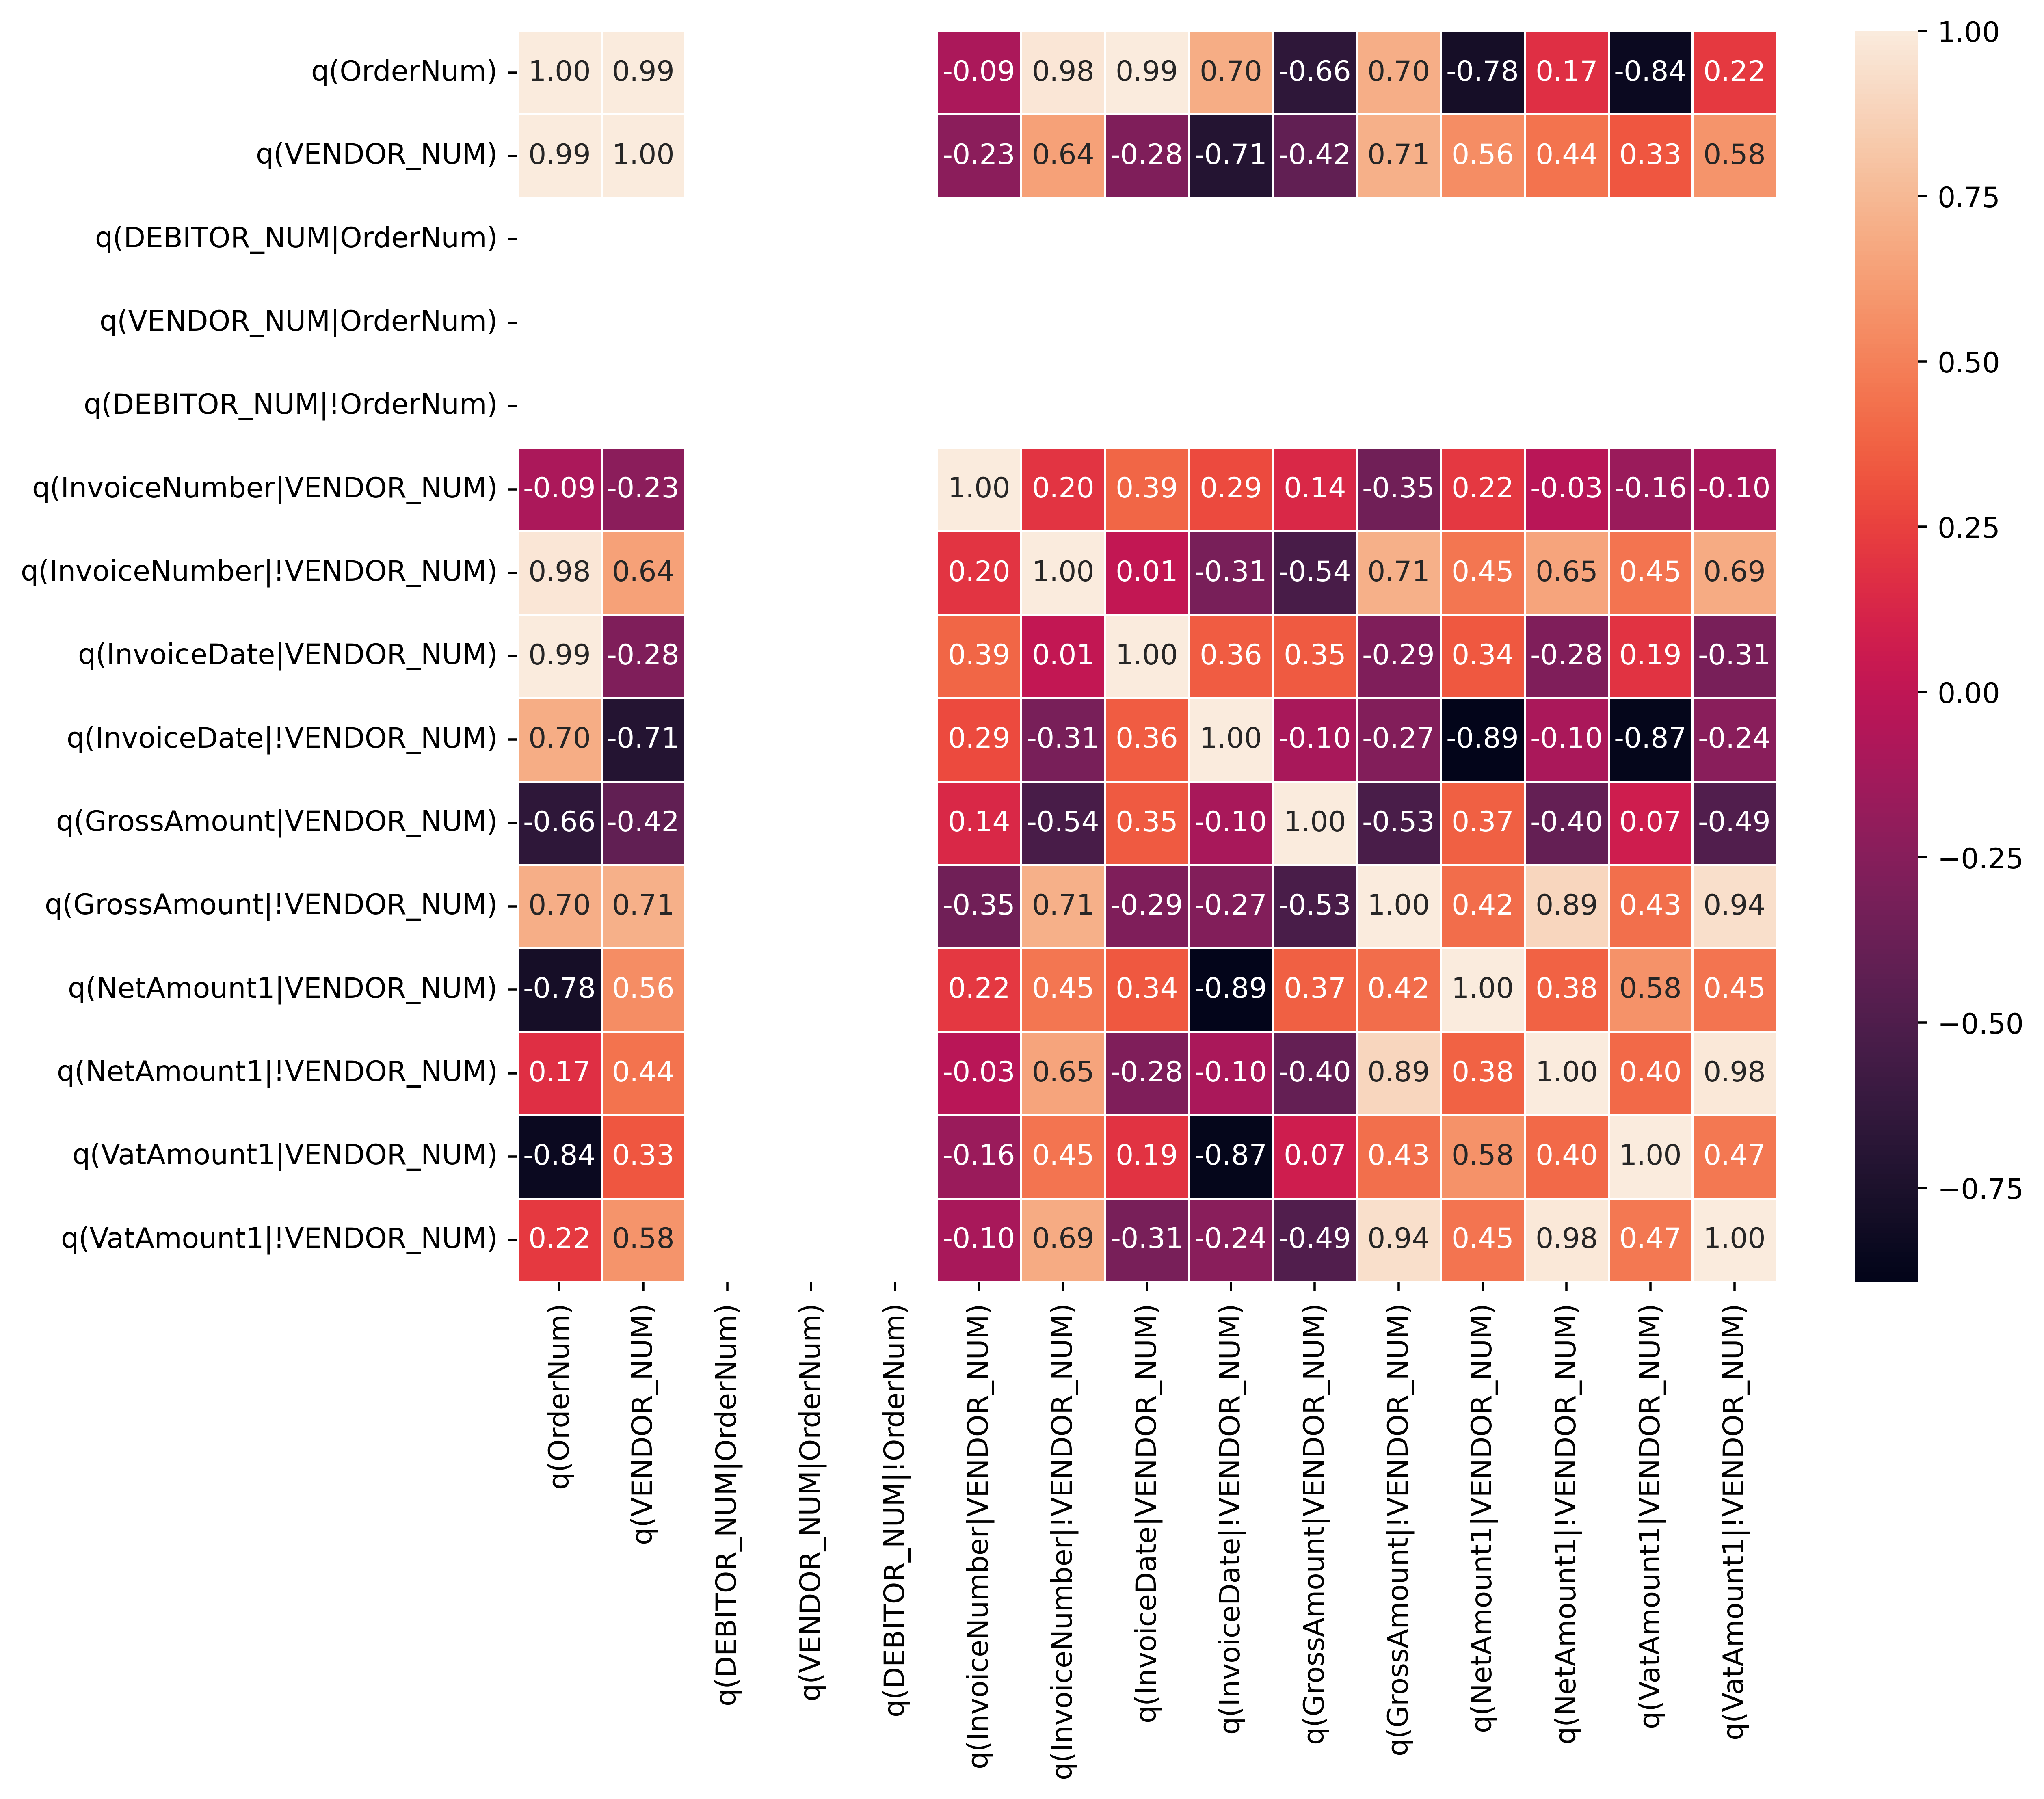

In [61]:
def handle_non_numerical_data_correlation(df):
    columns = df.columns.values
    for column in columns:
        text_digit_vals = {}
        def convert_to_int(val):
            return text_digit_vals[val]

        if df[column].dtype != np.int64 and df[column].dtype != np.float64:
            column_contents = df[column].values.tolist()
            unique_elements = set(column_contents)
            x = 0
            for unique in unique_elements:
                if unique not in text_digit_vals:
                    text_digit_vals[unique] = x
                    x+=1

            df[column] = list(map(convert_to_int, df[column]))

    return df


bc = handle_non_numerical_data_correlation(df1)

corr = df_results_debitor.corr(method = 'pearson')
corr
plt.figure(figsize=(10,8), dpi =500)
sns.heatmap(corr,annot=True,fmt=".2f", linewidth=.5)
plt.show()

In [47]:
target_attributes = ["Attribute_Name", "Attribute_After"]
target_df = bc[bc["Attribute_Name"].isin(target_attributes)]

# Berechnen Sie die Korrelationen der Zielzeilen mit den anderen Zeilen in "Attribute After"
corr_with_target = target_df["Attribute_After"].corrwith(bc["Attribute_After"])


AttributeError: 'Series' object has no attribute 'corrwith'

# Machine Learning


## Data preprocessing

In [54]:
df1 = pd.read_csv('data/cclogattributes_T0012hb.csv', encoding='iso-8859-15')

vergleiche_spalten = lambda x: 'master_data_error' if x['Attribute_Name'] == 'VENDOR_NUM' and x['Attribute_Before'] != x['Attribute_After'] else'good' if x['Delta'] == False and x['Type'] == 0 else 'undefined'
#else 'master_data_error' if x['Attribute_Name'] == 'VENDOR_NAME' and x['Attribute_Before'] != x['Attribute_After'] \
#else 'master_data_error' if x['Attribute_Name'] == 'VENDOR_STR' and x['Attribute_Before'] != x['Attribute_After'] \
#else 'master_data_error' if x['Attribute_Name'] == 'VENDOR_CITY' and x['Attribute_Before'] != x['Attribute_After'] \
#else 'master_data_error' if x['Attribute_Name'] == 'VENDOR_ZIP_CODE' and x['Attribute_Before'] != x['Attribute_After'] \

df1['Suggestion'] = df1.apply(vergleiche_spalten, axis=1)

df1 = df1.drop('LogTimeTicks', axis=1)
#df = df.drop('DocumentID', axis=1)

df1.to_csv('data/after_preprocessing.csv', index=False, header= True, encoding='iso-8859-15')

X = df1.loc[ : , df1.columns != 'Suggestion']
Y = df1.loc[ : , df1.columns == 'Suggestion']


In [20]:
def handle_non_numerical_data(df):
    columns = df.columns.values
    for column in columns:
        text_digit_vals = {}
        def convert_to_int(val):
            return text_digit_vals[val]

        if df[column].dtype != np.int64 and df[column].dtype != np.float64:
            column_contents = df[column].values.tolist()
            unique_elements = set(column_contents)
            x = 0
            for unique in unique_elements:
                if unique not in text_digit_vals:
                    text_digit_vals[unique] = x
                    x+=1

            df[column] = list(map(convert_to_int, df[column]))

    return df

#X = handle_non_numerical_data(X)


def Encoder(df):
          columnsToEncode = list(df.select_dtypes(include=['category','object','bool']))
          le = LabelEncoder()
          for feature in columnsToEncode:
              try:
                  df[feature] = le.fit_transform(df[feature])
              except:
                  print('Error encoding '+feature)
          return df


#Y = Encoder(Y)
#print(Y)
#pd.DataFrame(Y).to_csv("data/after_numerical.csv")


#print(X)
#X.shape[0]
#Y.shape[0]

In [4]:
#Create training and testing samples
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=None, shuffle=False)

pd.DataFrame(y_train).to_csv("data/y_train.csv")

## Create Model and Train

In [5]:
def create_model(optimizer='adam', init='uniform'):
    # create model
    if verbose: print("**Create model with optimizer: %s; init: %s" % (optimizer, init) )
    model = Sequential()
    model.add(Dense(16, input_dim=X_train.shape[1], kernel_initializer=init, activation='relu')) #
    model.add(Dense(512, kernel_initializer=init, activation='relu'))
    model.add(Dense(256, kernel_initializer=init, activation='relu'))
    model.add(Dense(3, kernel_initializer=init, activation='softmax'))
    # Compile model
    model.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.Adadelta(), metrics=['acc']) #keras.optimizers.Adadelta() and sparse_categorical_accuracy
    return model

In [46]:
run_gridsearch = False

if run_gridsearch:
    
    start_time = time.time()
    if verbose: print (time.strftime( "%H:%M:%S " + "GridSearch started ... " ) )
    optimizers = ['rmsprop'] # , 'adam'
    inits = ['glorot_uniform'] #, 'normal', 'uniform'
    epochs = [5, 50, 100, 300]
    batches = [5, 32, 64]
    
    model = KerasClassifier(build_fn=create_model, verbose=verbose)
    
    param_grid = dict(optimizer=optimizers, epochs=epochs, batch_size=batches, init=inits)
    grid = GridSearchCV(estimator=model, param_grid=param_grid)
    grid_result = grid.fit(X_train, y_train)

    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    if verbose: 
        for mean, stdev, param in zip(means, stds, params):
            print("%f (%f) with: %r" % (mean, stdev, param))
        elapsed_time = time.time() - start_time  
        print ("Time elapsed: ",timedelta(seconds=elapsed_time))
        
    best_epochs = grid_result.best_params_['epochs']
    best_batch_size = grid_result.best_params_['batch_size']
    best_init = grid_result.best_params_['init']
    best_optimizer = grid_result.best_params_['optimizer']
    
else:
    # best paramters
    best_epochs = 300
    best_batch_size = 64
    best_init = 'glorot_uniform'
    best_optimizer = 'rmsprop'

In [ ]:
results_df = pd.DataFrame(grid_result.cv_results_)
pd.DataFrame(results_df).to_csv('data/grid_search_results.csv')
results_df = results_df.sort_values(by=["rank_test_score"])
results_df = results_df.set_index(
    results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
).rename_axis("kernel")
results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]

In [ ]:
model_scores = results_df.filter(regex=r"split\d*_test_score")

# plot 30 examples of dependency between cv fold and AUC scores
fig, ax = plt.subplots()
sns.lineplot(
    data=model_scores.transpose().iloc[:30],
    dashes=False,
    palette="Set1",
    marker="o",
    alpha=0.5,
    ax=ax,
)
ax.set_xlabel("CV test fold", size=12, labelpad=10)
ax.set_ylabel("Model AUC", size=12)
ax.tick_params(bottom=True, labelbottom=False)
ax.legend(loc=4, prop={'size': 6})

plt.show()


In [ ]:
model_pred = KerasClassifier(build_fn=create_model, optimizer=best_optimizer, init=best_init, epochs=best_epochs, batch_size=best_batch_size, verbose=verbose)
model_pred.fit(X_train, y_train)

prediction = model_pred.predict(X_test)

# Evaluation

In [ ]:
print(classification_report(y_test, prediction, zero_division=False))
accuracy_score(y_test, prediction)

In [ ]:
print(prediction)
pd.DataFrame(prediction).to_csv('data/prediction.csv')

In [50]:
pickle.dump(model_pred, open('models/classification_model.h5', 'wb'))

In [ ]:
with open('models/classification_model.h5', 'rb') as pickle_file:
    content = pickle.load(pickle_file)

prediction = content.predict(X_test)
print(classification_report(y_test, prediction, zero_division=False))


In [ ]:
import pyautogui
import time
while True:
    for i in range(0,100):
        pyautogui.moveTo(10,10)
        pyautogui.leftClick()
        pyautogui.moveTo(1000,1000)
        pyautogui.leftClick()

        time.sleep(2)